# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "fig3.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.


---

monkey population CCA plot

In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [19]:
@utility.report
def plot_monkey_cca_prep(ax, ax_hist, full_list_MCx, allDFs_MCx):
    defs = monkey_defs
    
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    
    single_FileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            single_FileList1.append((I,J))
    n_iter = params.n_iter * 10
    side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
    side2df = [allDFs_MCx[j] for _,j in single_FileList1]
    AllData1 = defs._get_data_array(side1df, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllData1_ = defs._get_data_array(side2df, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T

    # Upper bound
    single_FileList1 = []
    for I, _ in enumerate(full_list_MCx):
        single_FileList1.append(I)
    side1df = [allDFs_MCx[i] for i in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllData1):
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    #plot the hist
    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05))

Executed: `plot_monkey_cca_prep` in 250.5s


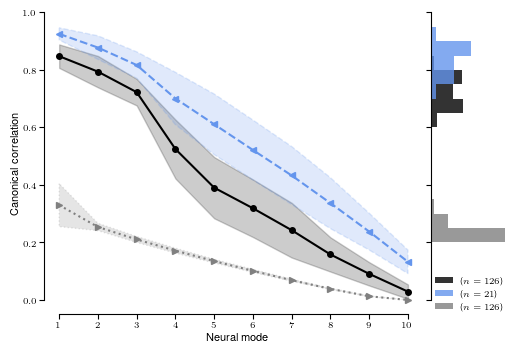

In [13]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca_prep(ax,ax_, full_list_MCx[10:13], allDFs_MCx)
    
    plt.show()

---

decoding for monkeys

In [16]:
@utility.report
def plot_monkey_target_decoding(ax, full_list, allDFs):
    defs = monkey_defs

    reg_scores = []
    for i, df in enumerate(allDFs):
        AllData = dt.get_data_array([df], defs.prep_epoch, area=defs.areas[2], model=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        n_trial = int(AllData.shape[-3] /2)
        AllData1 = AllData[0,:,:n_trial, :,:]
        AllData2 = AllData[0,:,-n_trial:,:,:]
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        
        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_comp*n_time))
        V = V.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
        trial_index = np.arange(len(AllTar))
        params.rng.shuffle(trial_index)
        X_train, Y_train = U[trial_index,:], AllTar[trial_index]
        params.rng.shuffle(trial_index)
        X_test, Y_test   = V[trial_index,:], AllTar[trial_index]
        # train the decoder
        classifier_model = GaussianNB
        classifier = classifier_model()
        classifier.fit(X_train, Y_train)
        # test the decoder
        _score = classifier.score(X_test,Y_test)
        reg_scores.append((i,_score))
    pop_score_within_day = []
    for _,scores in reg_scores:
        pop_score_within_day.append(scores)
    pop_score_within_day = np.array(pop_score_within_day)


    #=================================
    pairIndex_across = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndex_across.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]
    
    reg_scores_across = []
    for id1, testId in pairIndex_across:
        AllData = dt.get_data_array([allDFs[id1],allDFs[testId]], defs.prep_epoch, area=defs.areas[2], model=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

        AllData1 = AllData[0,...] 
        AllData2 = AllData[1,...]
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        AllData1 = AllData1[:,:n_trial,:n_time,:]
        AllData2 = AllData2[:,:n_trial,:n_time,:]

        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))

        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        U = U.reshape((-1,n_comp*n_time))
        V = V.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
        trial_index = np.arange(len(AllTar))
        params.rng.shuffle(trial_index)
        X_train, Y_train = U[trial_index,:], AllTar[trial_index]
        params.rng.shuffle(trial_index)
        X_test, Y_test   = V[trial_index,:], AllTar[trial_index]

        # train the decoder
        classifier = classifier_model()
        classifier.fit(X_train, Y_train)
        # test the decoder
        _score = classifier.score(X_test,Y_test)
        reg_scores_across.append((id1,testId,_score))
    pop_score_across_animals = []
    for _,_,scores in reg_scores_across:
        pop_score_across_animals.append(scores)
    pop_score_across_animals = np.array(pop_score_across_animals)

    #=======================================
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData = dt.get_data_array([allDFs[id1],allDFs[testId]], defs.prep_epoch, area=defs.areas[2], model=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

        AllData1 = AllData[0,...] 
        AllData2 = AllData[1,...]
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        AllData1 = AllData1[:,:n_trial,:n_time,:]
        AllData2 = AllData2[:,:n_trial,:n_time,:]

        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
    #     *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        X1 = X1.reshape((-1,n_comp*n_time))
        X2 = X2.reshape((-1,n_comp*n_time))
        AllTar = np.repeat(np.arange(defs.n_targets),n_trial)
        trial_index = np.arange(len(AllTar))
        params.rng.shuffle(trial_index)
        X_train, Y_train = X1[trial_index,:], AllTar[trial_index]
        params.rng.shuffle(trial_index)
        X_test, Y_test   = X2[trial_index,:], AllTar[trial_index]
        # train the decoder
        classifier = classifier_model()
        classifier.fit(X_train, Y_train)
        # test the decoder
        _score = classifier.score(X_test,Y_test)
        reg_latent_scores.append((id1,testId,_score))
    pop_score_latent_across = []
    for _,_,scores in reg_latent_scores:
        pop_score_latent_across.append(scores)
    pop_score_latent_across = np.array(pop_score_latent_across)

#======================== PLOTTING

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across_animals, bins=bins, density=True, label=r'Across (\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_score_latent_across, bins=bins, density=True, label=r'Across (\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_within_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)

    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_ylabel('Probability density')
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    # ax.legend(loc=(0,.7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_target_decoding(ax, full_list_MCx, allDFs_MCx)
    
    plt.show()

---

Mouse CCA plot

In [3]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [20]:
@utility.report
def plot_mouse_str_cca(ax, ax_hist, allDFs_Str):
    defs = mouse_defs

    pairFileList2 = []
    for I, df1 in enumerate(allDFs_Str):
        for J, df2 in enumerate(allDFs_Str):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList2.append((I,J))

    side1df = [allDFs_Str[i] for i,_ in pairFileList2]
    side2df = [allDFs_Str[j] for _,j in pairFileList2]
    AllData1_ = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
    AllData2_ = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
    _,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
        data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData2 = dt.get_data_array(allDFs_Str, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
    n_shared_trial2 = AllData2.shape[2]
    trialList2 = np.arange(n_shared_trial2)
    n_iter = params.n_iter * 10
    CCsU=[]
    for sessionData in AllData2:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList2)
            # non-overlapping randomised trials
            trial1 = trialList2[:n_shared_trial2//2]
            trial2 = trialList2[-(n_shared_trial2//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    pairFileList2 = []
    for I, df1 in enumerate(allDFs_Str):
        for J, df2 in enumerate(allDFs_Str):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList2.append((I,J))
    side1df = [allDFs_Str[i] for i,_ in pairFileList2]
    side2df = [allDFs_Str[j] for _,j in pairFileList2]
    AllData1_ = dt.get_data_array(side1df, area=defs.areas[1], model=defs.n_components)
    AllData2_ = dt.get_data_array(side2df, area=defs.areas[1], model=defs.n_components)
    _,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time_-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials_,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials_,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05))

Executed: `plot_mouse_str_cca` in 8.9s


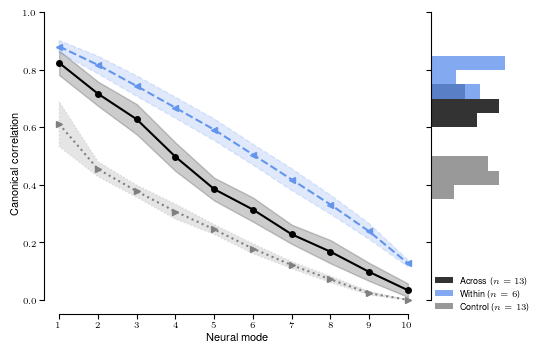

In [4]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # _, allDFs_Str = get_full_mouse_data()
    
    plot_mouse_str_cca(ax,ax_, allDFs_Str)
    
    plt.show()

---

STR decoding

In [21]:
@utility.report
def plot_str_decoding(ax, AllDFs):
    defs = mouse_defs

    reg_scores = []
    for i, df in enumerate(AllDFs):
        AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[1], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        _,_,n_trial,n_time,n_comp = AllData.shape
        half_trials = int(n_trial /2)
        AllData1 = AllData[0,...][:,:half_trials, :,:]
        AllData2 = AllData[0,...][:,-half_trials:,:,:]
        AllVel1 = AllVel[0,...][:,:half_trials, :,:]
        AllVel2 = AllVel[0,...][:,-half_trials:,:,:]

        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))
        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))

        # train the decoder
        Y_train_x,Y_train_y, Y_train_z = AllVel1.T[:,goodIndex]
        Y_test_x,Y_test_y, Y_test_z = AllVel2.T[:,goodIndex]
        x_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=10).mean()
        y_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=10).mean()
        z_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_z,Y_test_z)),scoring=defs.custom_r2_scorer, cv=10).mean()
        reg_scores.append((i,(x_score,y_score,z_score)))
    pop_score_day = []
    for _,scores in reg_scores:
        pop_score_day.append(np.mean(scores))
    pop_score_day = np.array(pop_score_day)


    #=========================
    pairIndex_across = []
    for i, df1 in enumerate(AllDFs):
        animal1 = df1.mouse[0]
        pairIndex_across.append((i,[]))
        for j, df2 in enumerate(AllDFs):
            if j<i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]
    reg_scores_across = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[1], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))
        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
        # train the decoder
        *_,U,V = dt.canoncorr(X1[goodIndex,:], X2[goodIndex,:], fullReturn=True)
        Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
        reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        reg_z.fit(U, Y_train_z)
        # test the decoder
        Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
        reg_scores_across.append((id1,testId,(x_score,y_score,z_score)))
    pop_score_across = []
    for _,_,scores in reg_scores_across:
        pop_score_across.append(np.mean(scores))
    pop_score_across = np.array(pop_score_across)

    #================================
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[1], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))
        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
        # train the decoder
        U,V = X1[goodIndex,:], X2[goodIndex,:]
        Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
        reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        reg_z.fit(U, Y_train_z)
        # test the decoder
        Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
        reg_latent_scores.append((id1,testId,(x_score,y_score,z_score)))
    pop_latent_score = []
    for _,_,scores in reg_latent_scores:
        pop_latent_score.append(np.mean(scores))
    pop_latent_score = np.array(pop_latent_score)



#======================== PLOTTING

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label='Across\n' r'(\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_latent_score, bins=bins, density=True, label='Across\n' r'(\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)

    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_ylabel('Probability density')
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])

Executed: `plot_str_decoding` in 9.2s


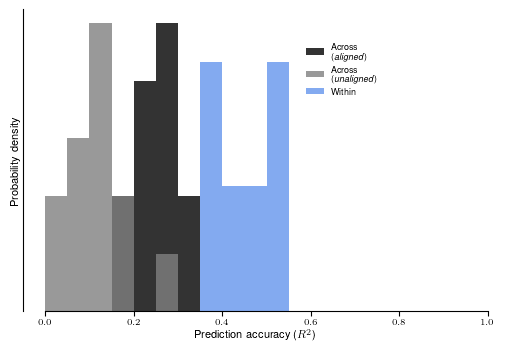

In [15]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # _, allDFs_Str = get_full_mouse_data()
    
    plot_str_decoding(ax, allDFs_Str)
    
    plt.show()

# Part 2
Plot figure

Executed: `get_full_mouse_data` in 0.8s
Executed: `plot_mouse_str_cca` in 9.5s
Executed: `plot_str_decoding` in 5.2s
Executed: `get_full_monkey_data` in 15.9s
Executed: `plot_monkey_cca_prep` in 261.5s
Executed: `plot_monkey_target_decoding` in 357.7s


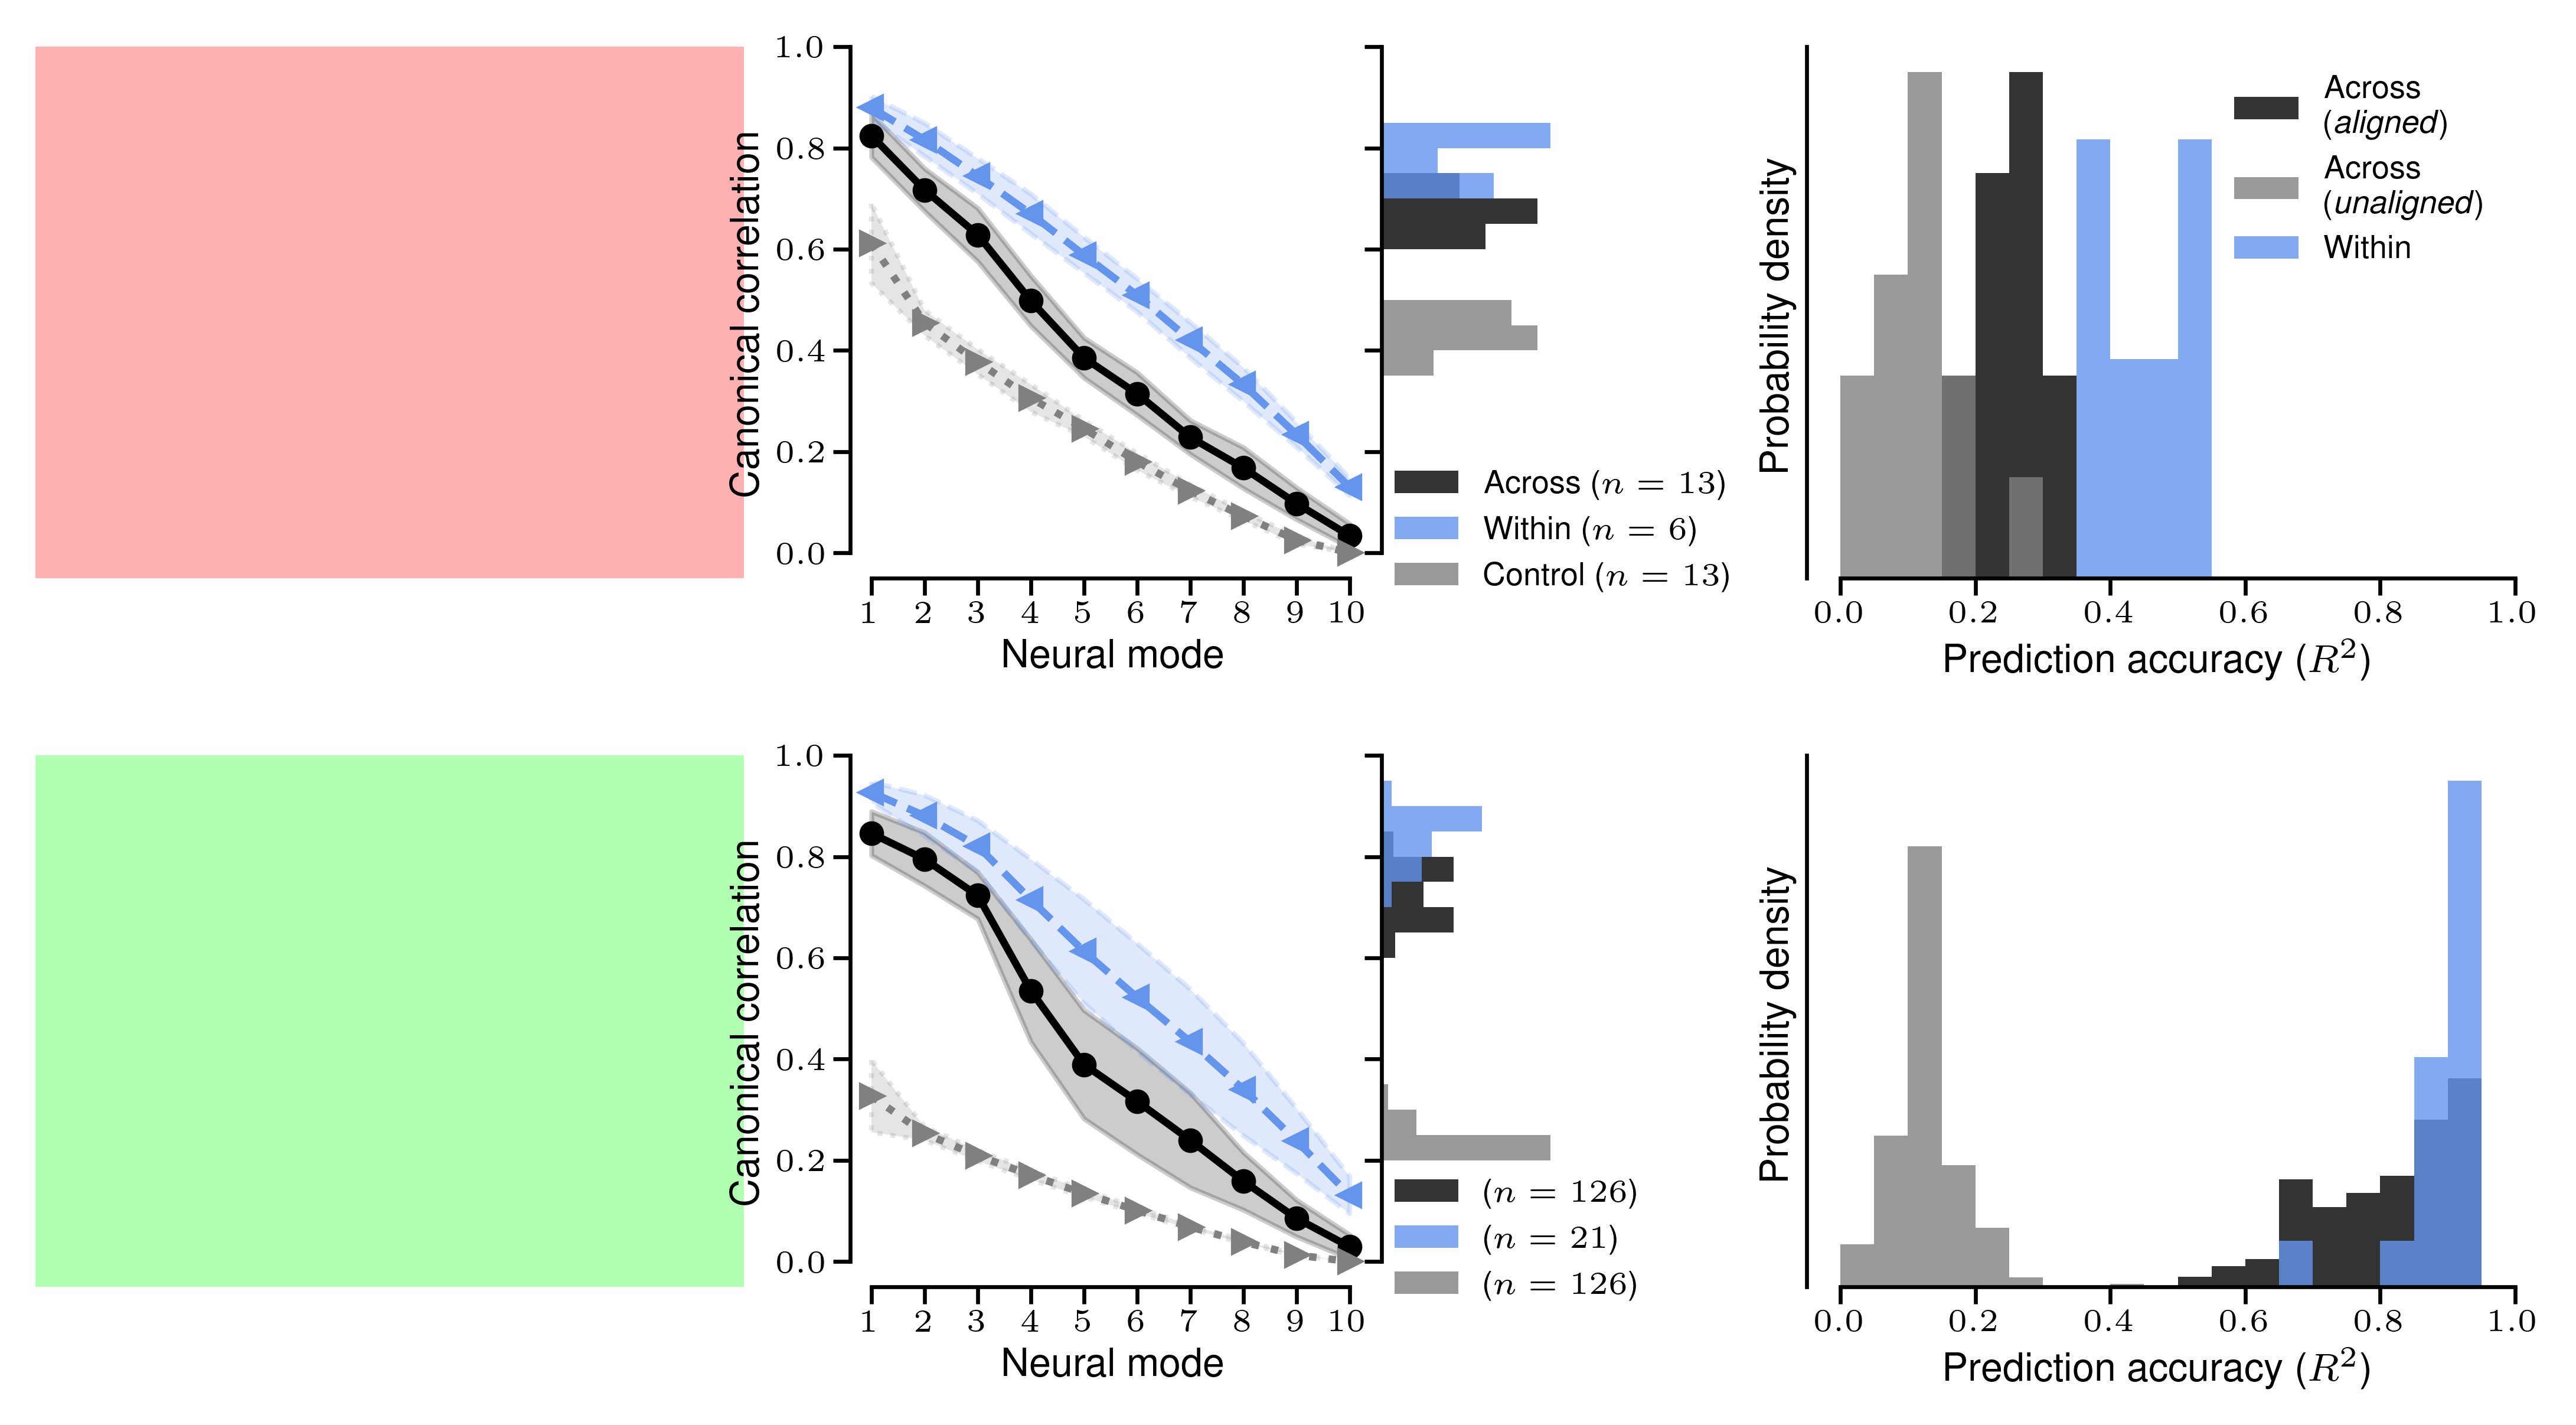

In [22]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= (params.LargeFig[0], params.panels.SmallH*2+.3)
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: STR schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, top=figsize[1], 
                                    right=params.panels.schmatic[0],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca_hist[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([1,0,0,.3])


    
    
    ##########################################
    # 2: CCA plot for Str
    gs2 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs1.right+(.3/figsize[0]),  # .7" offset
                           right=gs1.right+ (.3/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs1.bottom,
                           top=gs1.top,
                           wspace=0)

    ax2 = fig.add_subplot(gs2[0])
    ax2_ = fig.add_subplot(gs2[1])

    _, allDFs_Str = get_full_mouse_data()
    
    plot_mouse_str_cca(ax2,ax2_, allDFs_Str)

    
    
    
    ##########################################
    # 3: Decoding for STR
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax3 = fig.add_subplot(gs3[0])

       
    plot_str_decoding(ax3, allDFs_Str)
    
    
    ##########################################
    # 4: schematics Prep
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=gs1.bottom*figsize[1]-params.panels.schmatic[1],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca_hist[1])
    ax4   =fig.add_subplot(gs4[0])
    ax4 = utility.phantom_axes(ax4)
    ax4.set_facecolor([0,1,0,.3])

    
    
    
    ##########################################
    # 5: CCA plot for PREP
    gs5 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs2.left,
                           right=gs2.right,
                           bottom=gs4.bottom,
                           top=gs4.top,
                           wspace=0)

    ax5 = fig.add_subplot(gs5[0])
    ax5_ = fig.add_subplot(gs5[1])
    
    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca_prep(ax5,ax5_, full_list_MCx, allDFs_MCx)
    

    
    ##########################################
    # 6: Decoding for target
    gs6   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs5.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax6 = fig.add_subplot(gs6[0])

       
    plot_monkey_target_decoding(ax6, full_list_MCx, allDFs_MCx)


    ##########################################

    fig.savefig(params.figPath / 'figure3.pdf', format='pdf', bbox_inches='tight')